# Spiking neural networks for EMG data streaming

In [1]:
import os
import sys
sys.path.append("..")
sys.path.insert(0,"/s2net-emg")

!pip install librosa==0.9.1
!pip install pandas
!pip install numpy==1.21.4
!pip install numba==0.53.0
!pip install scipy
!pip install torch
!pip install torchvision
!pip install matplotlib
import scipy
from scipy import signal
import time
import numpy as np
import librosa
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
import torchvision


from utils import plot_spk_rec, plot_mem_rec
from models import SNN, SpikingConv2DLayer, ReadoutLayer, SurrogateHeaviside, SpikingDenseLayer

from data import EMGDataset, PSD, STFT, PSDNoDelta, NoFeatureExtraction, Rescale
from optim import RAdam

In [2]:
# Different feature extraction functions
# 0 - No feature extraction
# 1 - PSD
# 2 - STFT
# 3 - PSDNoDelta
MODE = 1
# Load pretrained model?
LOAD = False

In [3]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/magnapinna/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


# Loading Data

In [4]:
train_data_root = "../data/train"
test_data_root = "../data/test"

training_words = os.listdir(train_data_root)
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x))]
training_words = [x for x in training_words if os.path.isdir(os.path.join(train_data_root,x)) if x[0] != "_" ]
print("{} training words:".format(len(training_words)))
print(training_words)

8 training words:
['8', '6', '3', '2', '1', '5', '7', '4']


In [5]:
testing_words = os.listdir(test_data_root)
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x))]
testing_words = [x for x in testing_words if os.path.isdir(os.path.join(train_data_root,x)) 
                 if x[0] != "_"]
print("{} testing words:".format(len(testing_words)))
if len(testing_words) != len(training_words):
    raise ValueError("Mismathed data")
print(testing_words)

8 testing words:
['8', '6', '3', '2', '1', '5', '7', '4']


In [6]:
# Using labels from datasets
lb = sorted(testing_words)
label_dct = {lb[i]: i for i in range(len(lb))}
if len(testing_words) != len(label_dct.keys()):
    raise ValueError("Mismathed data")
print("label_dct:")
print(label_dct)

label_dct:
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7}


In [7]:
sr = 150
size = 150
n_fft = size
hop_length = 20

In [8]:
stft = STFT(n_fft, hop_length)
psd = PSD(sr, n_fft)
psdnodelta = PSDNoDelta(sr, n_fft)
nfe = NoFeatureExtraction()

rescale = Rescale()

if MODE == 0:
    transform = torchvision.transforms.Compose([nfe, rescale])
    in_chan = 1
    in_sh = 8
elif MODE == 1:
    transform = torchvision.transforms.Compose([psd, rescale])
    in_chan = 2
    in_sh = 8
elif MODE == 2:
    transform = torchvision.transforms.Compose([stft, rescale])
    in_chan = 8
    in_sh = 52
elif MODE == 3:
    transform = torchvision.transforms.Compose([psdnodelta, rescale])
    in_chan = 1
    in_sh = 8
else:
    print("Incorect mode, using no transform")
    transform = torchvision.transforms.Compose([nfs, rescale])
    in_chan = 1
    in_sh = 8



def collate_fn(data):
    
    X_batch = np.array([d[0] for d in data])
    std = X_batch.std(axis=(0,3), keepdims=True)
    X_batch = torch.tensor(X_batch/std)
    
    y_batch = torch.tensor([d[1] for d in data])
    
    return X_batch, y_batch 
 

In [9]:
batch_size = 20

train_dataset = EMGDataset(train_data_root, label_dct, transform = transform, mode="train", max_nb_per_class=None)
train_sampler = torch.utils.data.WeightedRandomSampler(train_dataset.weights,len(train_dataset.weights))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler, collate_fn=collate_fn)

test_dataset = EMGDataset(test_data_root, label_dct, transform = transform, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Creating the model

In [18]:
spike_fn = SurrogateHeaviside.apply

w_init_std = 0.15
w_init_mean = 0.

w_init_std = 0.15
w_init_mean = 0.


layers = []
in_channels = in_chan
out_channels = 64
kernel_size = (4,3)
dilation = (1,1)
input_shape = in_sh
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True))

in_channels = out_channels
out_channels = 64
kernel_size = (4,3)
dilation = (4,3)
input_shape = output_shape
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                              lateral_connections=True))

in_channels = out_channels
out_channels = 64
kernel_size = (4,3)
dilation = (4,3)
input_shape = output_shape
output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv2DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
                               lateral_connections=True, flatten_output=True))

# previous layer output has been flattened
input_shape = output_shape*out_channels
output_shape = 10
time_reduction="mean" #mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

X_batch, _ = next(iter(train_dataloader))
X_batch = X_batch.to(device, dtype)
snn(X_batch)

for i,l in enumerate(snn.layers):
    if isinstance(l, SpikingDenseLayer) or isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))

Layer 0: average number of spikes=0.3357
Layer 1: average number of spikes=0.2171
Layer 2: average number of spikes=0.1361


In [19]:
#LOADING MODEL
if LOAD:
    if MODE == 1:
        snn.load_state_dict(torch.load("../saved/modeldictPSD.pt", map_location=device))
    elif MODE == 2:
        snn.load_state_dict(torch.load("../saved/modeldictSTFT.pt", map_location=device))
    elif MODE == 3:
        snn.load_state_dict(torch.load("../saved/modeldictPSDNoDelta.pt", map_location=device))  
    else:
        snn.load_state_dict(torch.load("../saved/modeldictNOFE.pt", map_location=device))


# Training and plotting

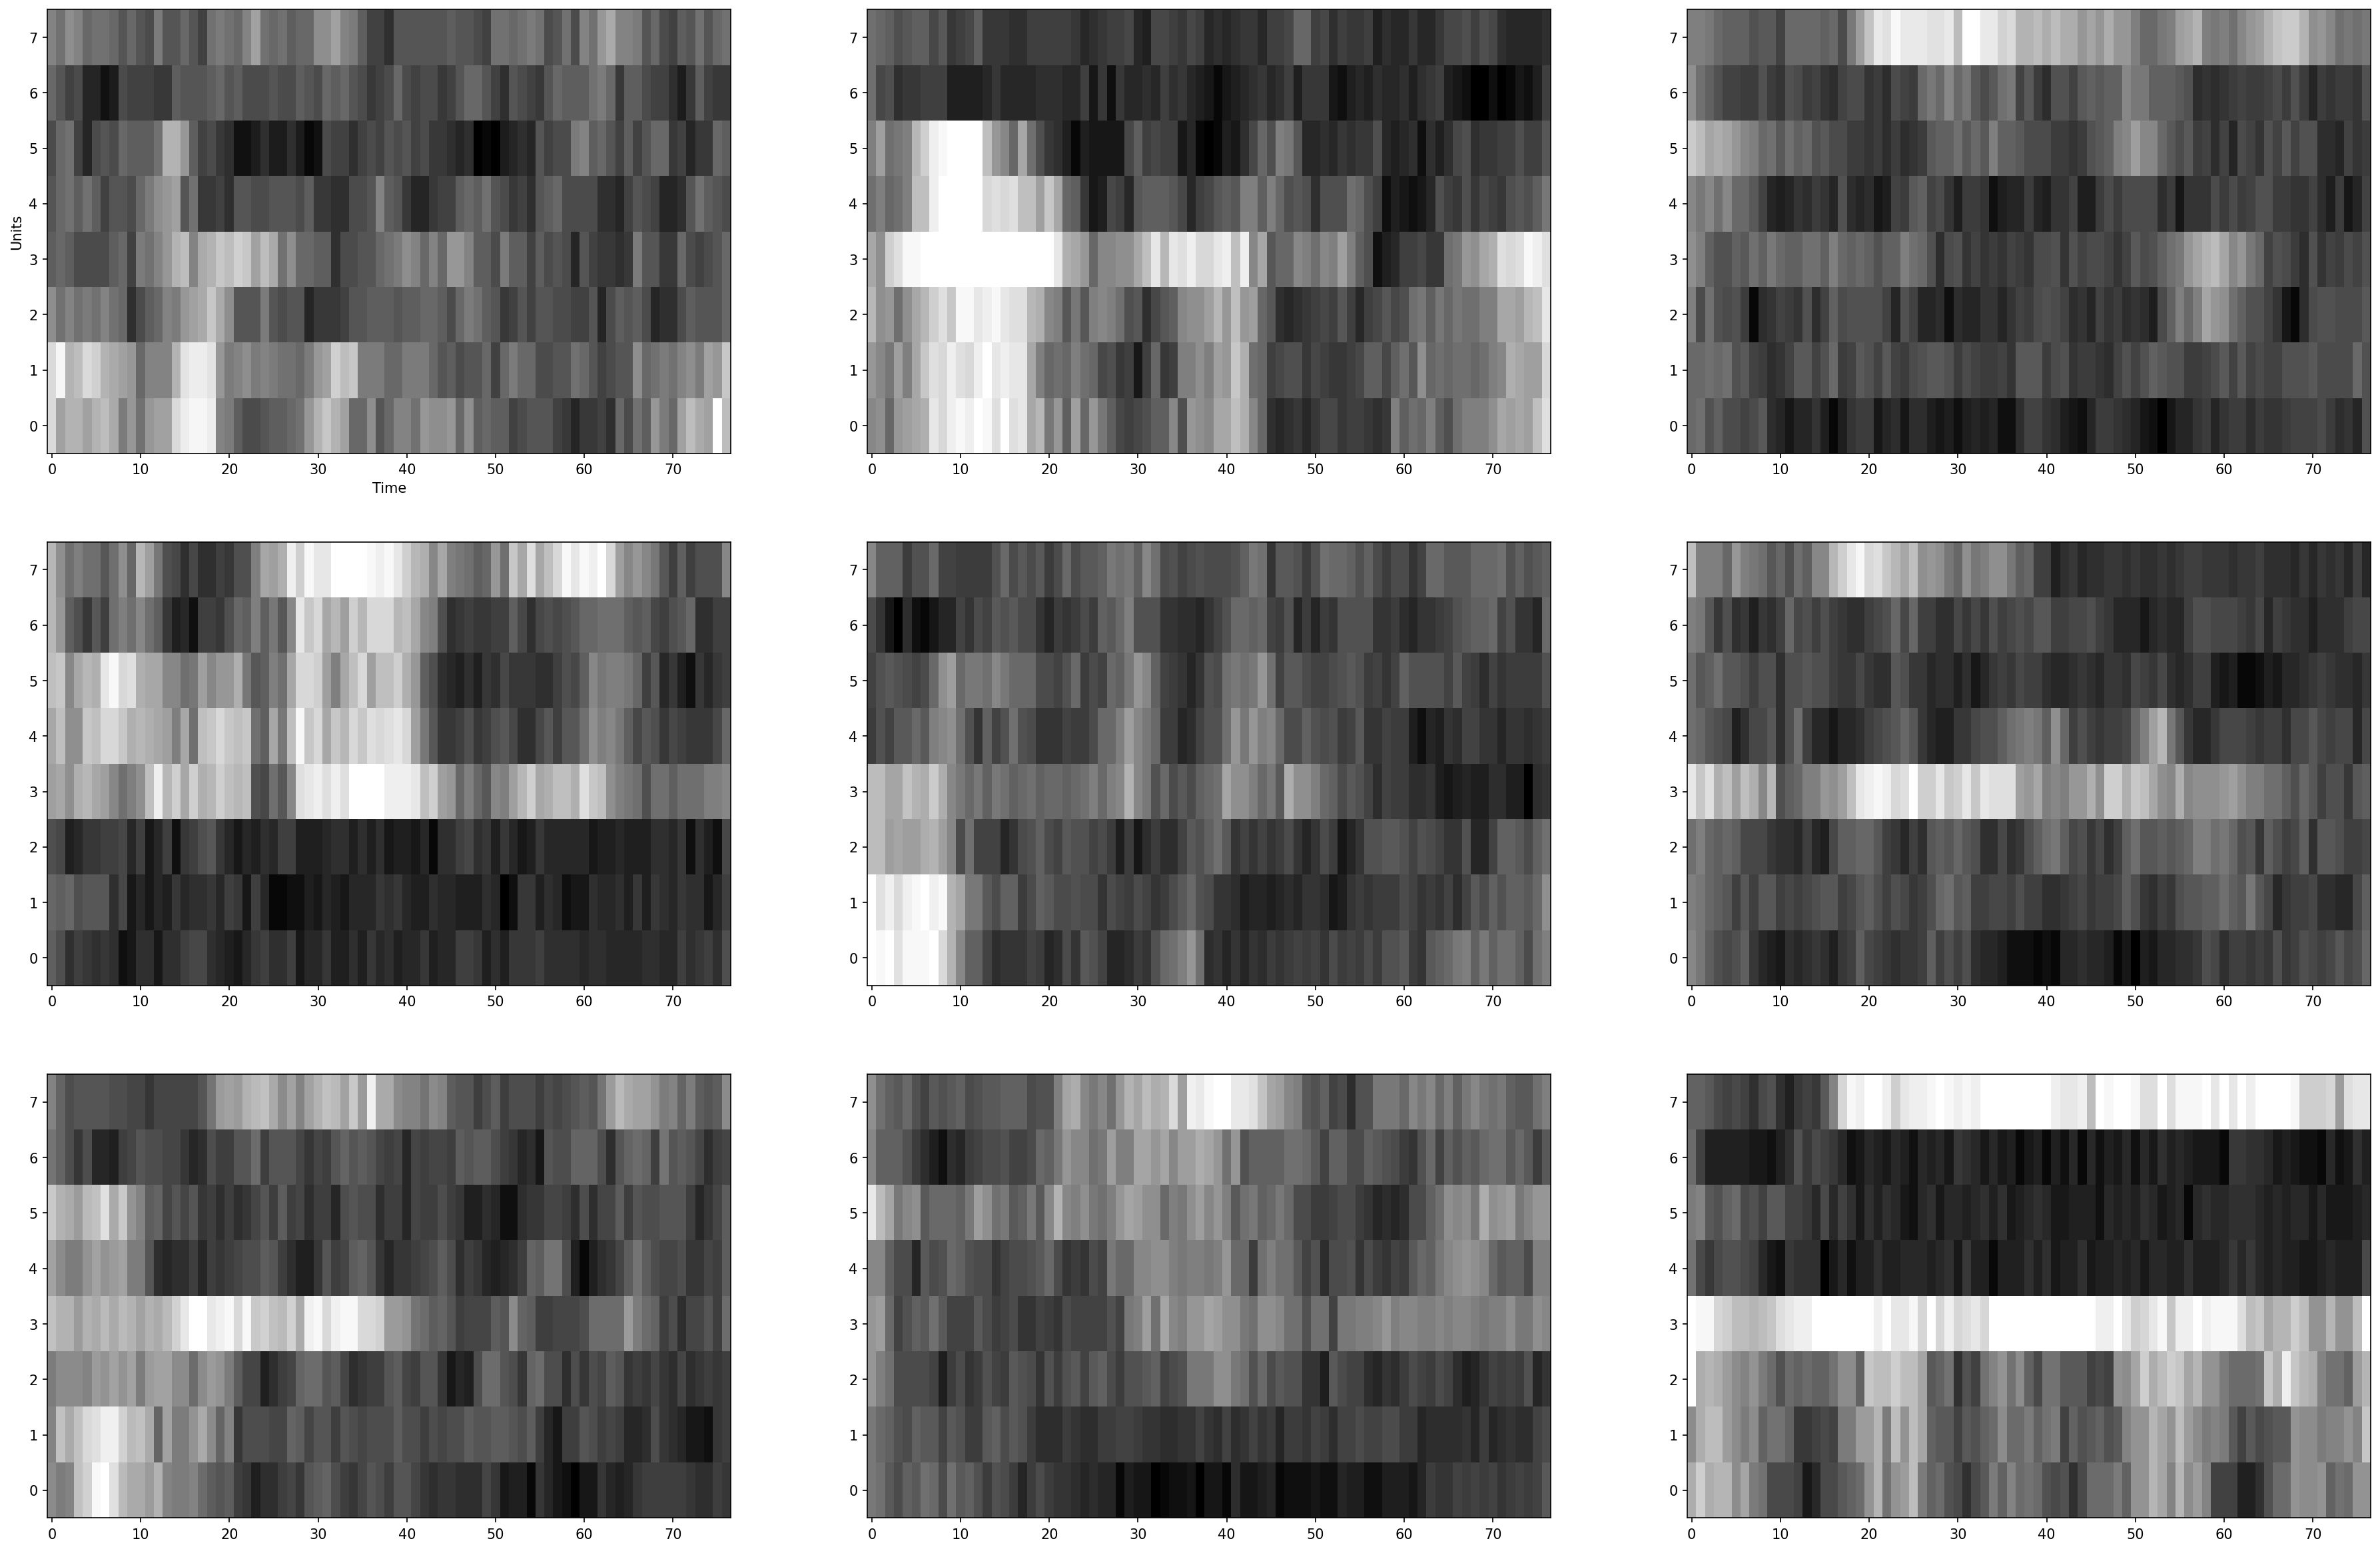

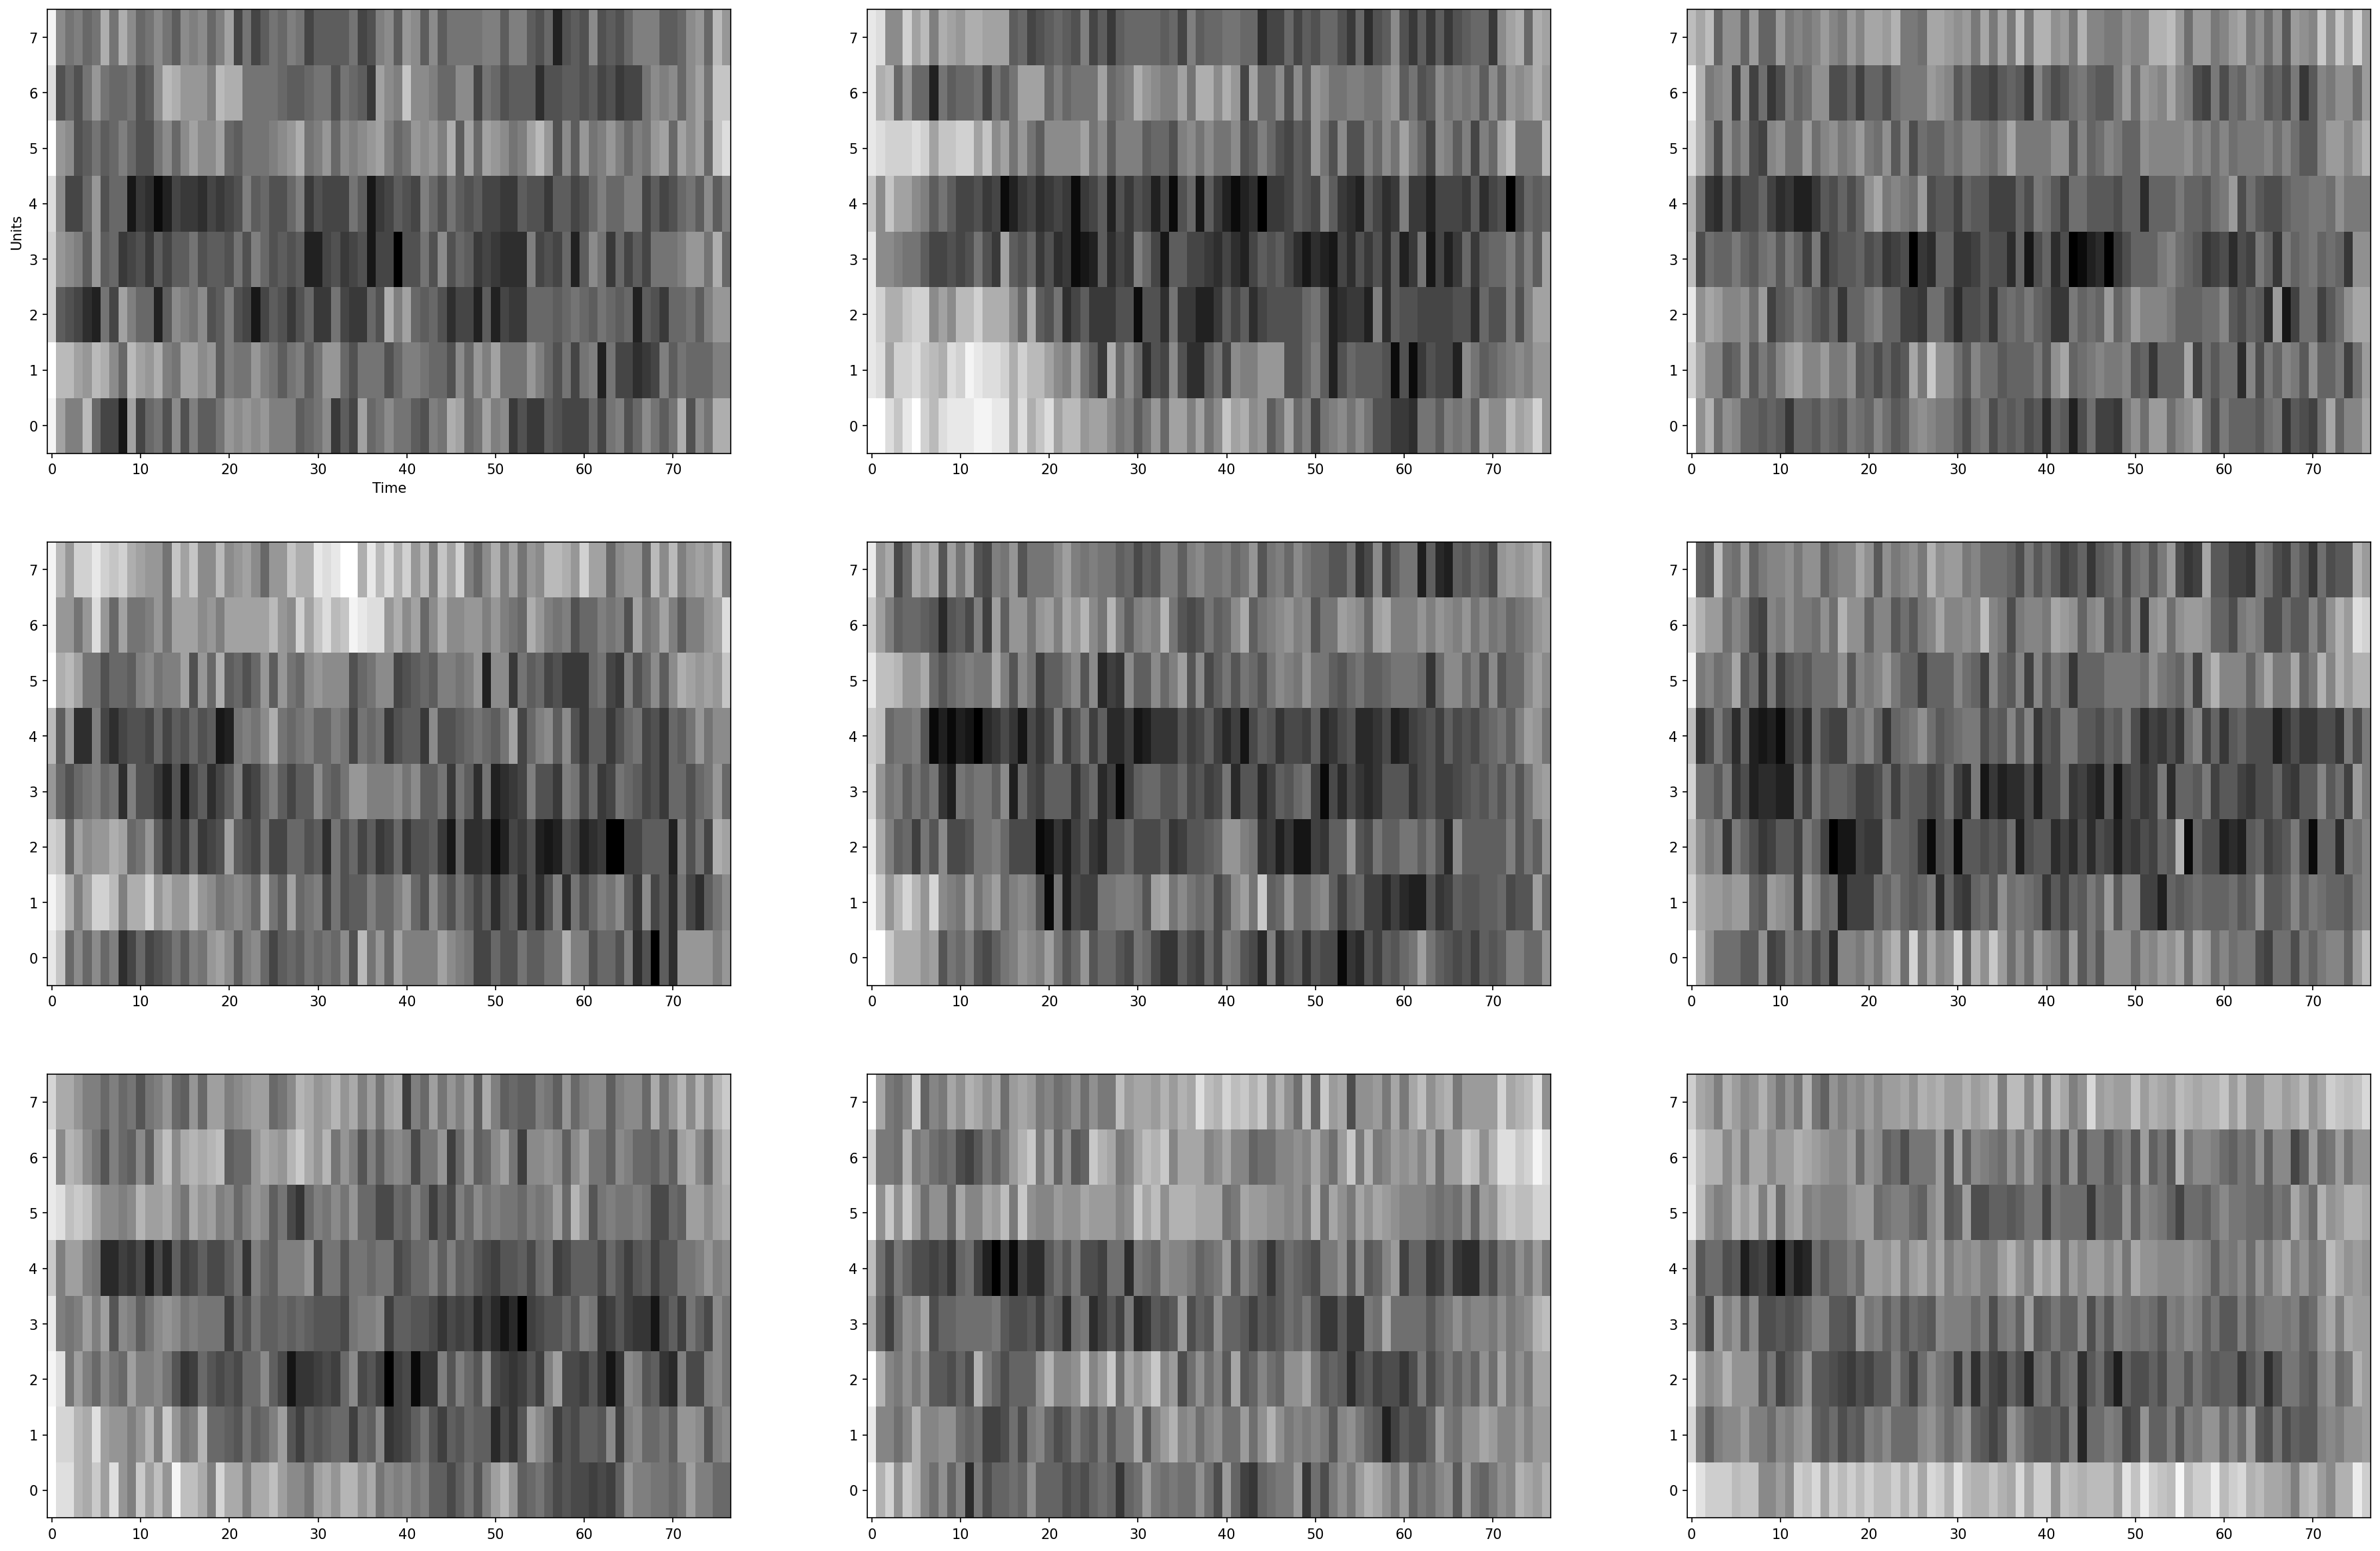

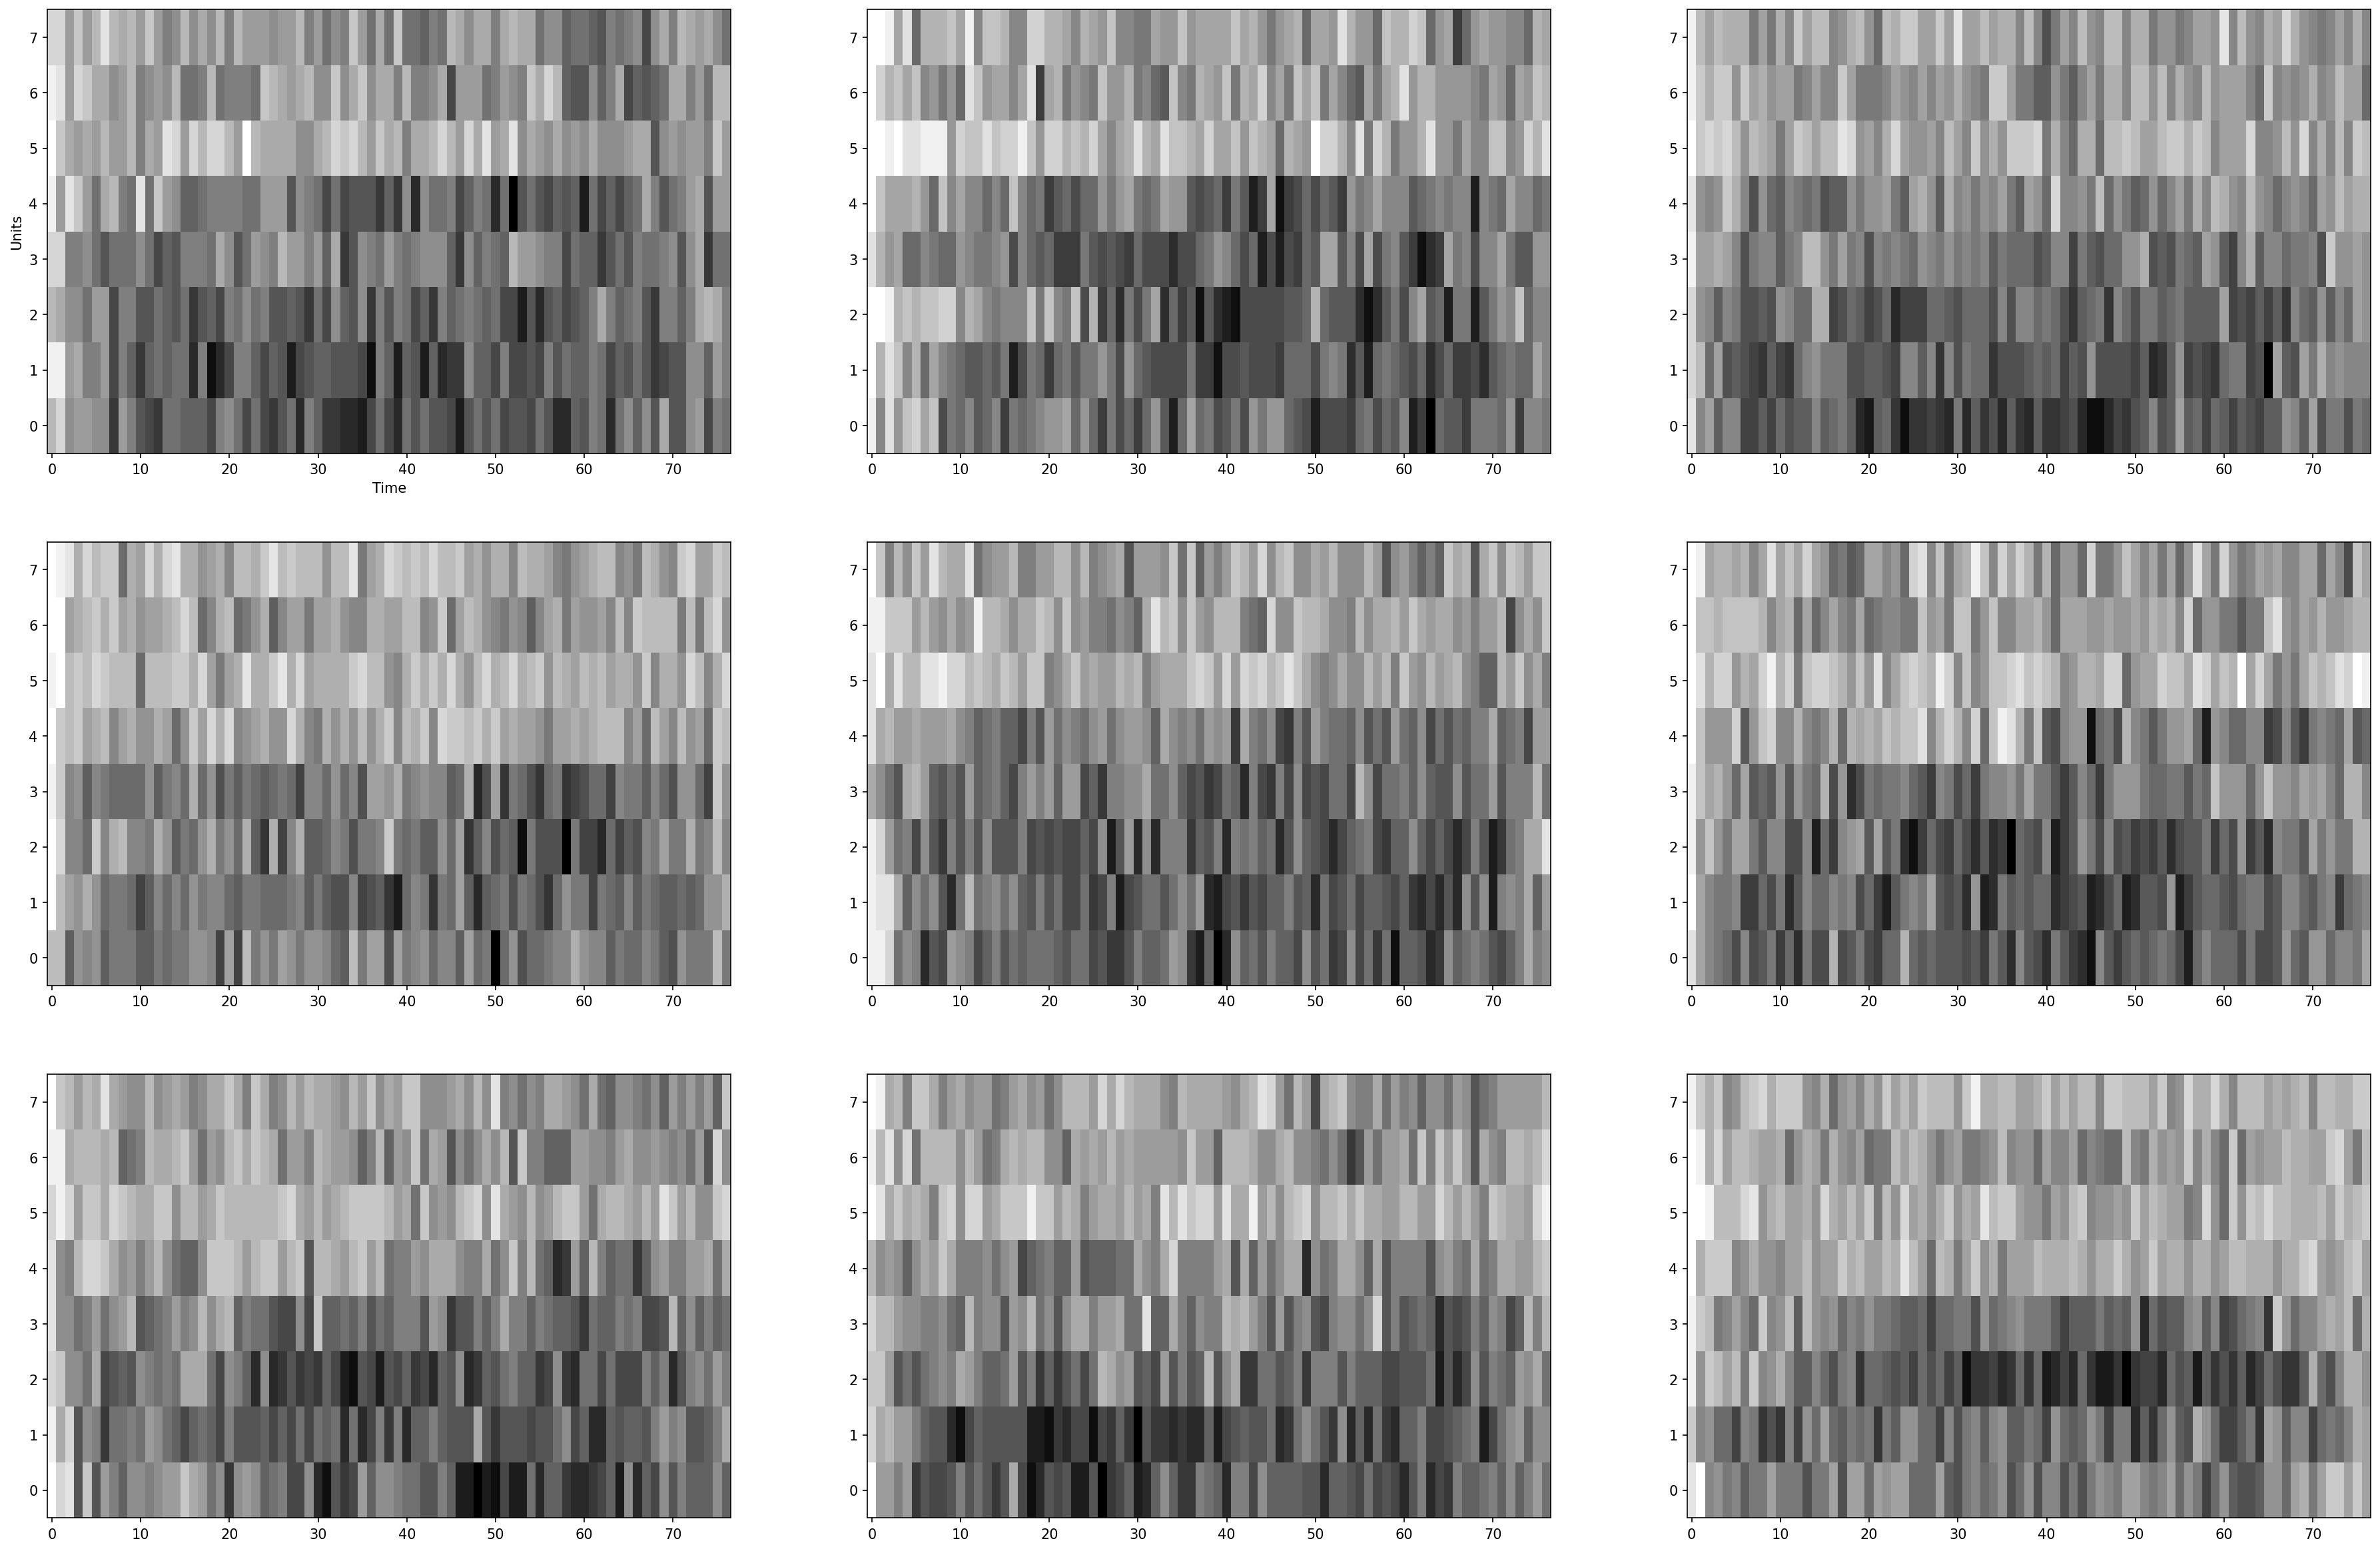

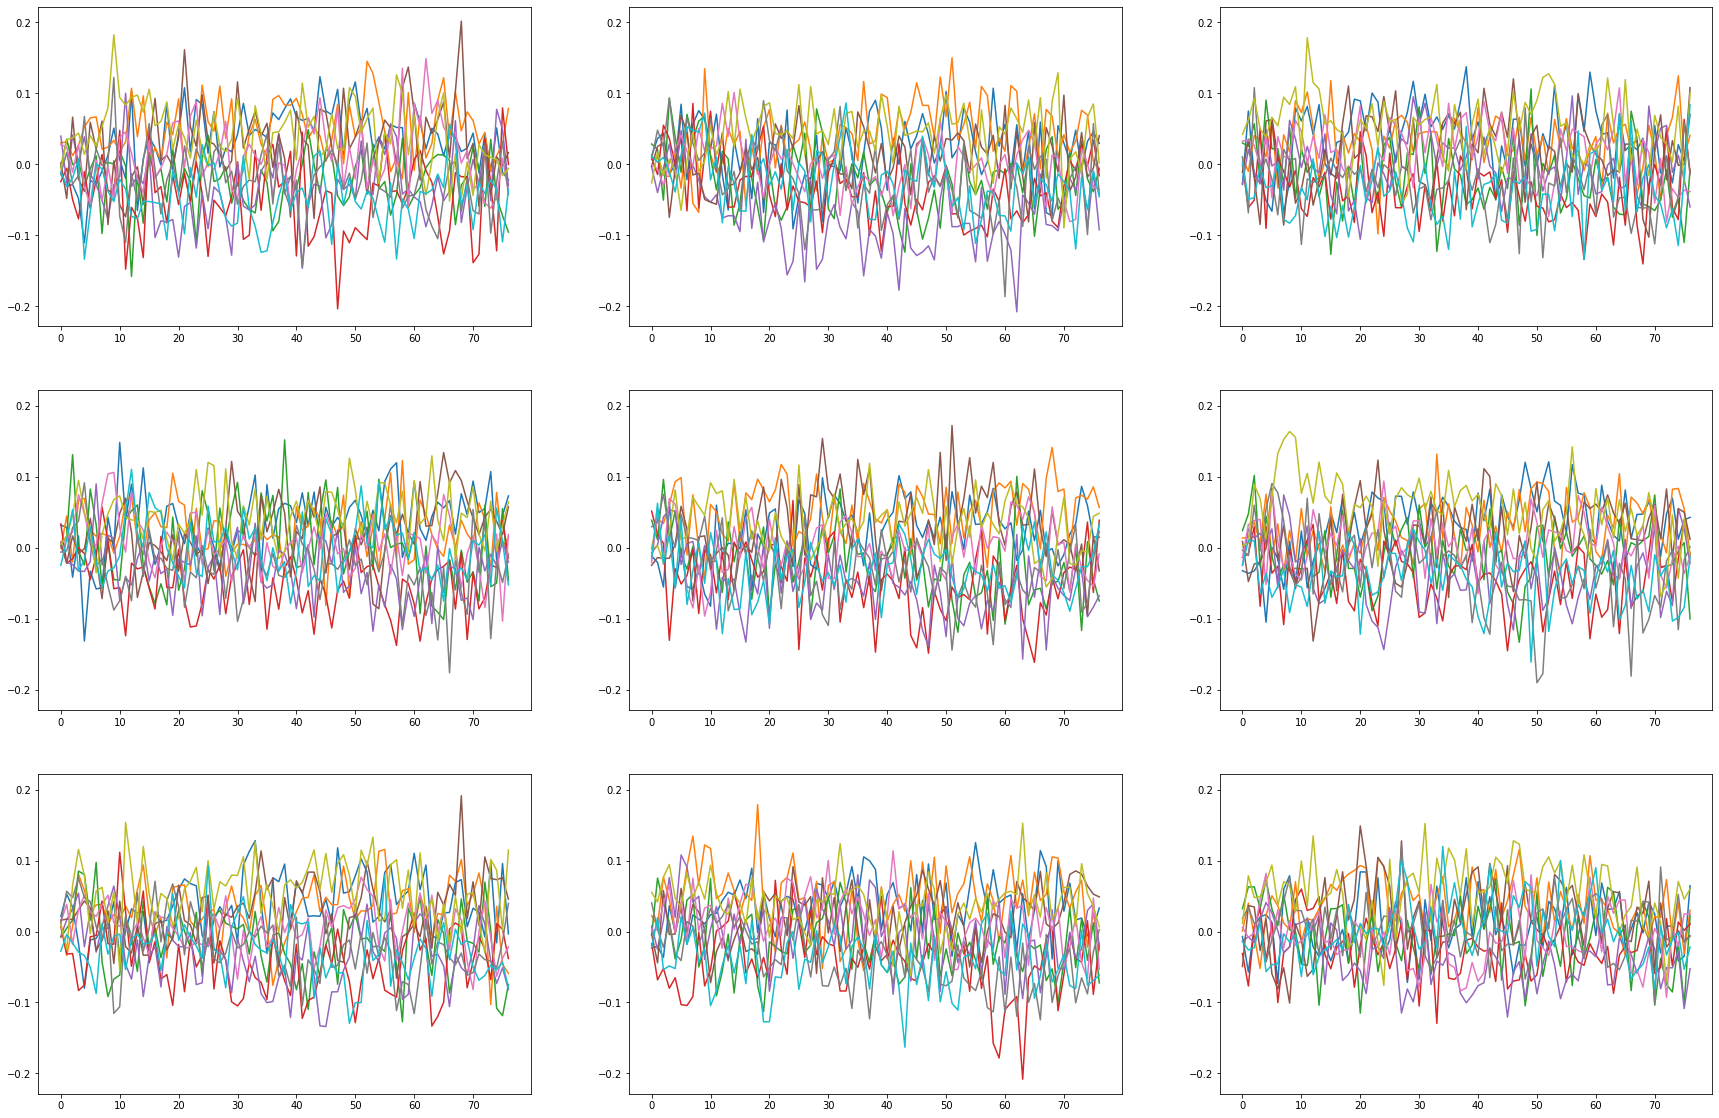

In [20]:
nb_plt = 9

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [21]:
def train(model, params, optimizer, train_dataloader, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= len(train_dataloader)*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[]}
    for e in range(nb_epochs):
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        for x_batch, y_batch in train_dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)

            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

            for i,loss in enumerate(loss_seq[:-1]):
                reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
                loss_val += reg_loss_val
                reg_loss[i].append(reg_loss_val.item())


            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()

            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        

    return hist
        
def compute_classification_accuracy(model, dataloader):
    accs = []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
    return np.mean(accs)

In [22]:
if LOAD == False:
    lr = 1e-3
    weight_decay = 1e-5
    reg_loss_coef = 0.1
    nb_epochs = 10
    warmup_epochs = 1

    params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
    params += [{'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
    params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
    if snn.layers[-1].time_reduction == "mean":
        params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
    elif snn.layers[-1].time_reduction == "max":
        params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
    else:
        raise ValueError("Readout time recution should be 'max' or 'mean'")
    
    optimizer = RAdam(params)
 
    gamma = 0.85
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

    hist = train(snn, params, optimizer, train_dataloader, reg_loss_coef, nb_epochs=nb_epochs,
                    scheduler=scheduler, warmup_epochs=1)


Epoch 1: loss=1.00582
Layer 0: reg loss=0.00503
Layer 1: reg loss=0.00708
Layer 2: reg loss=0.00793
Layer 0: average number of spikes=0.3020
Layer 1: average number of spikes=0.1854
Layer 2: average number of spikes=0.1599
Epoch 2: loss=0.43618
Layer 0: reg loss=0.00469
Layer 1: reg loss=0.00536
Layer 2: reg loss=0.00703
Layer 0: average number of spikes=0.2679
Layer 1: average number of spikes=0.1252
Layer 2: average number of spikes=0.1280
Epoch 3: loss=0.28089
Layer 0: reg loss=0.00422
Layer 1: reg loss=0.00423
Layer 2: reg loss=0.00674
Layer 0: average number of spikes=0.2395
Layer 1: average number of spikes=0.1061
Layer 2: average number of spikes=0.1224
Epoch 4: loss=0.21795
Layer 0: reg loss=0.00386
Layer 1: reg loss=0.00375
Layer 2: reg loss=0.00697
Layer 0: average number of spikes=0.2107
Layer 1: average number of spikes=0.1052
Layer 2: average number of spikes=0.1377
Epoch 5: loss=0.21650
Layer 0: reg loss=0.00354
Layer 1: reg loss=0.00335
Layer 2: reg loss=0.00640
Layer 0:

KeyboardInterrupt: 

In [ ]:
test_accuracy = compute_classification_accuracy(snn, test_dataloader)
print("Test accuracy=%.3f"%(test_accuracy))

Layer 0: average number of spikes=0.2667
Layer 1: average number of spikes=0.2153


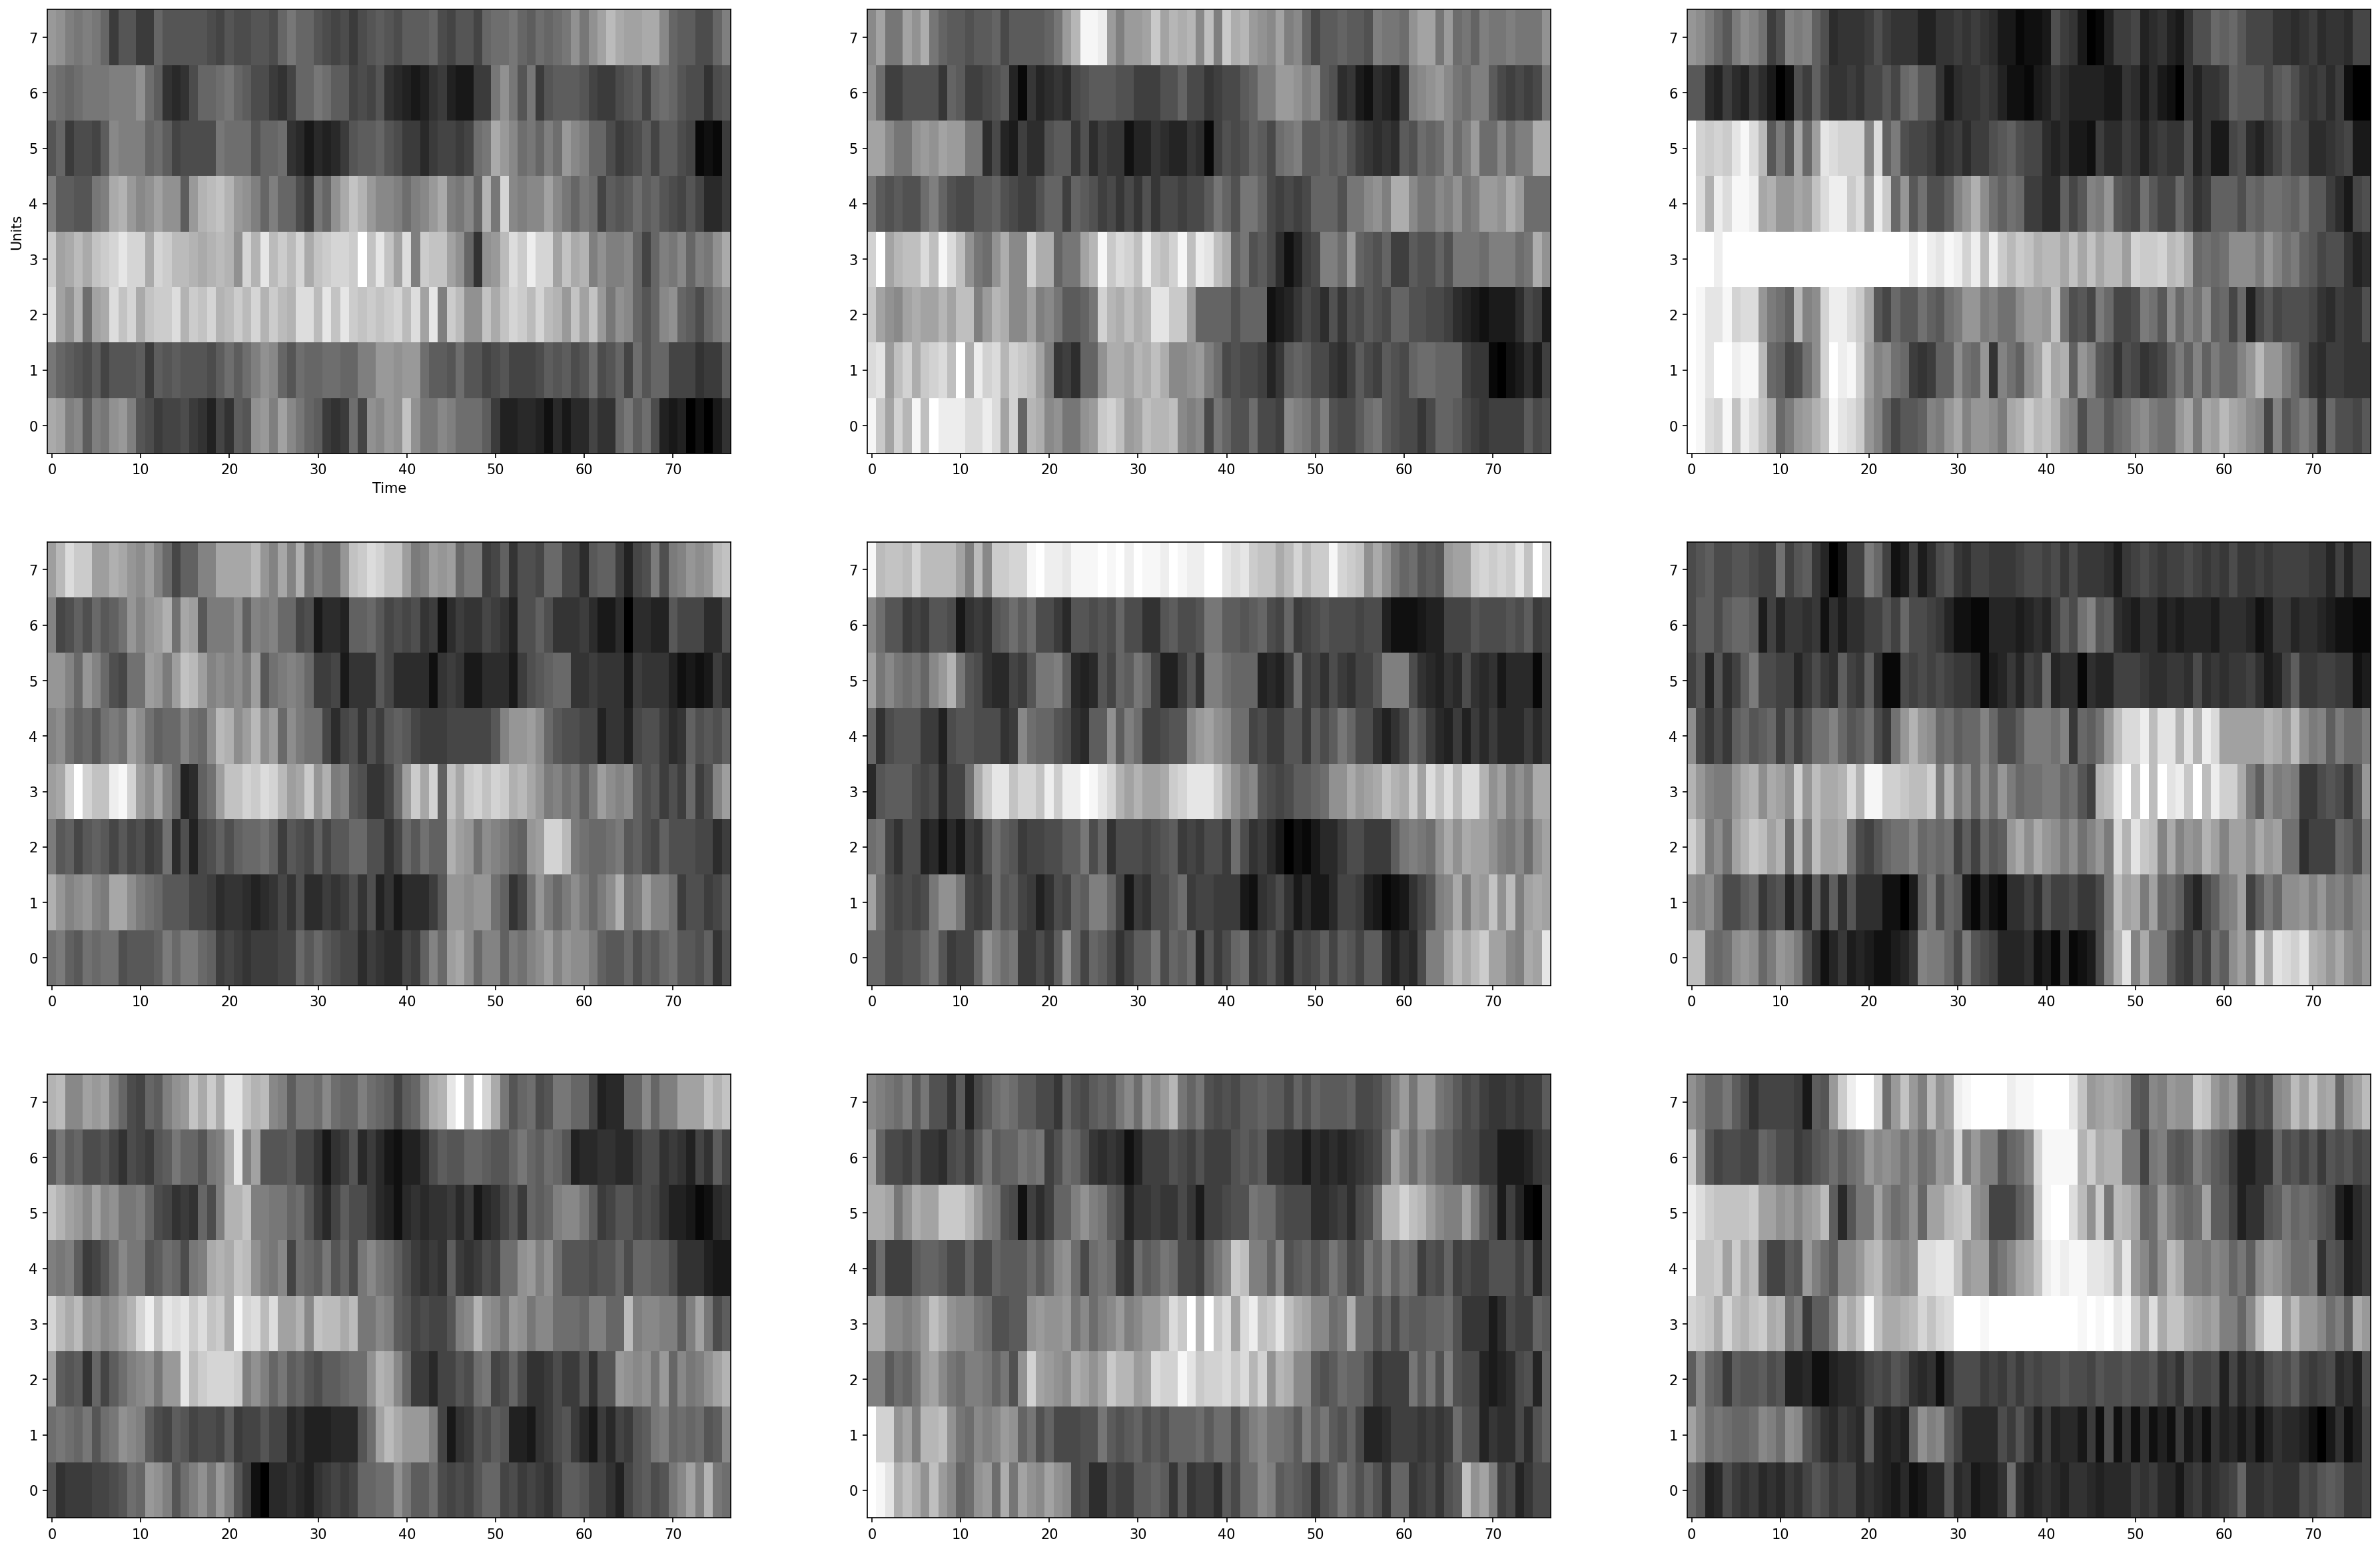

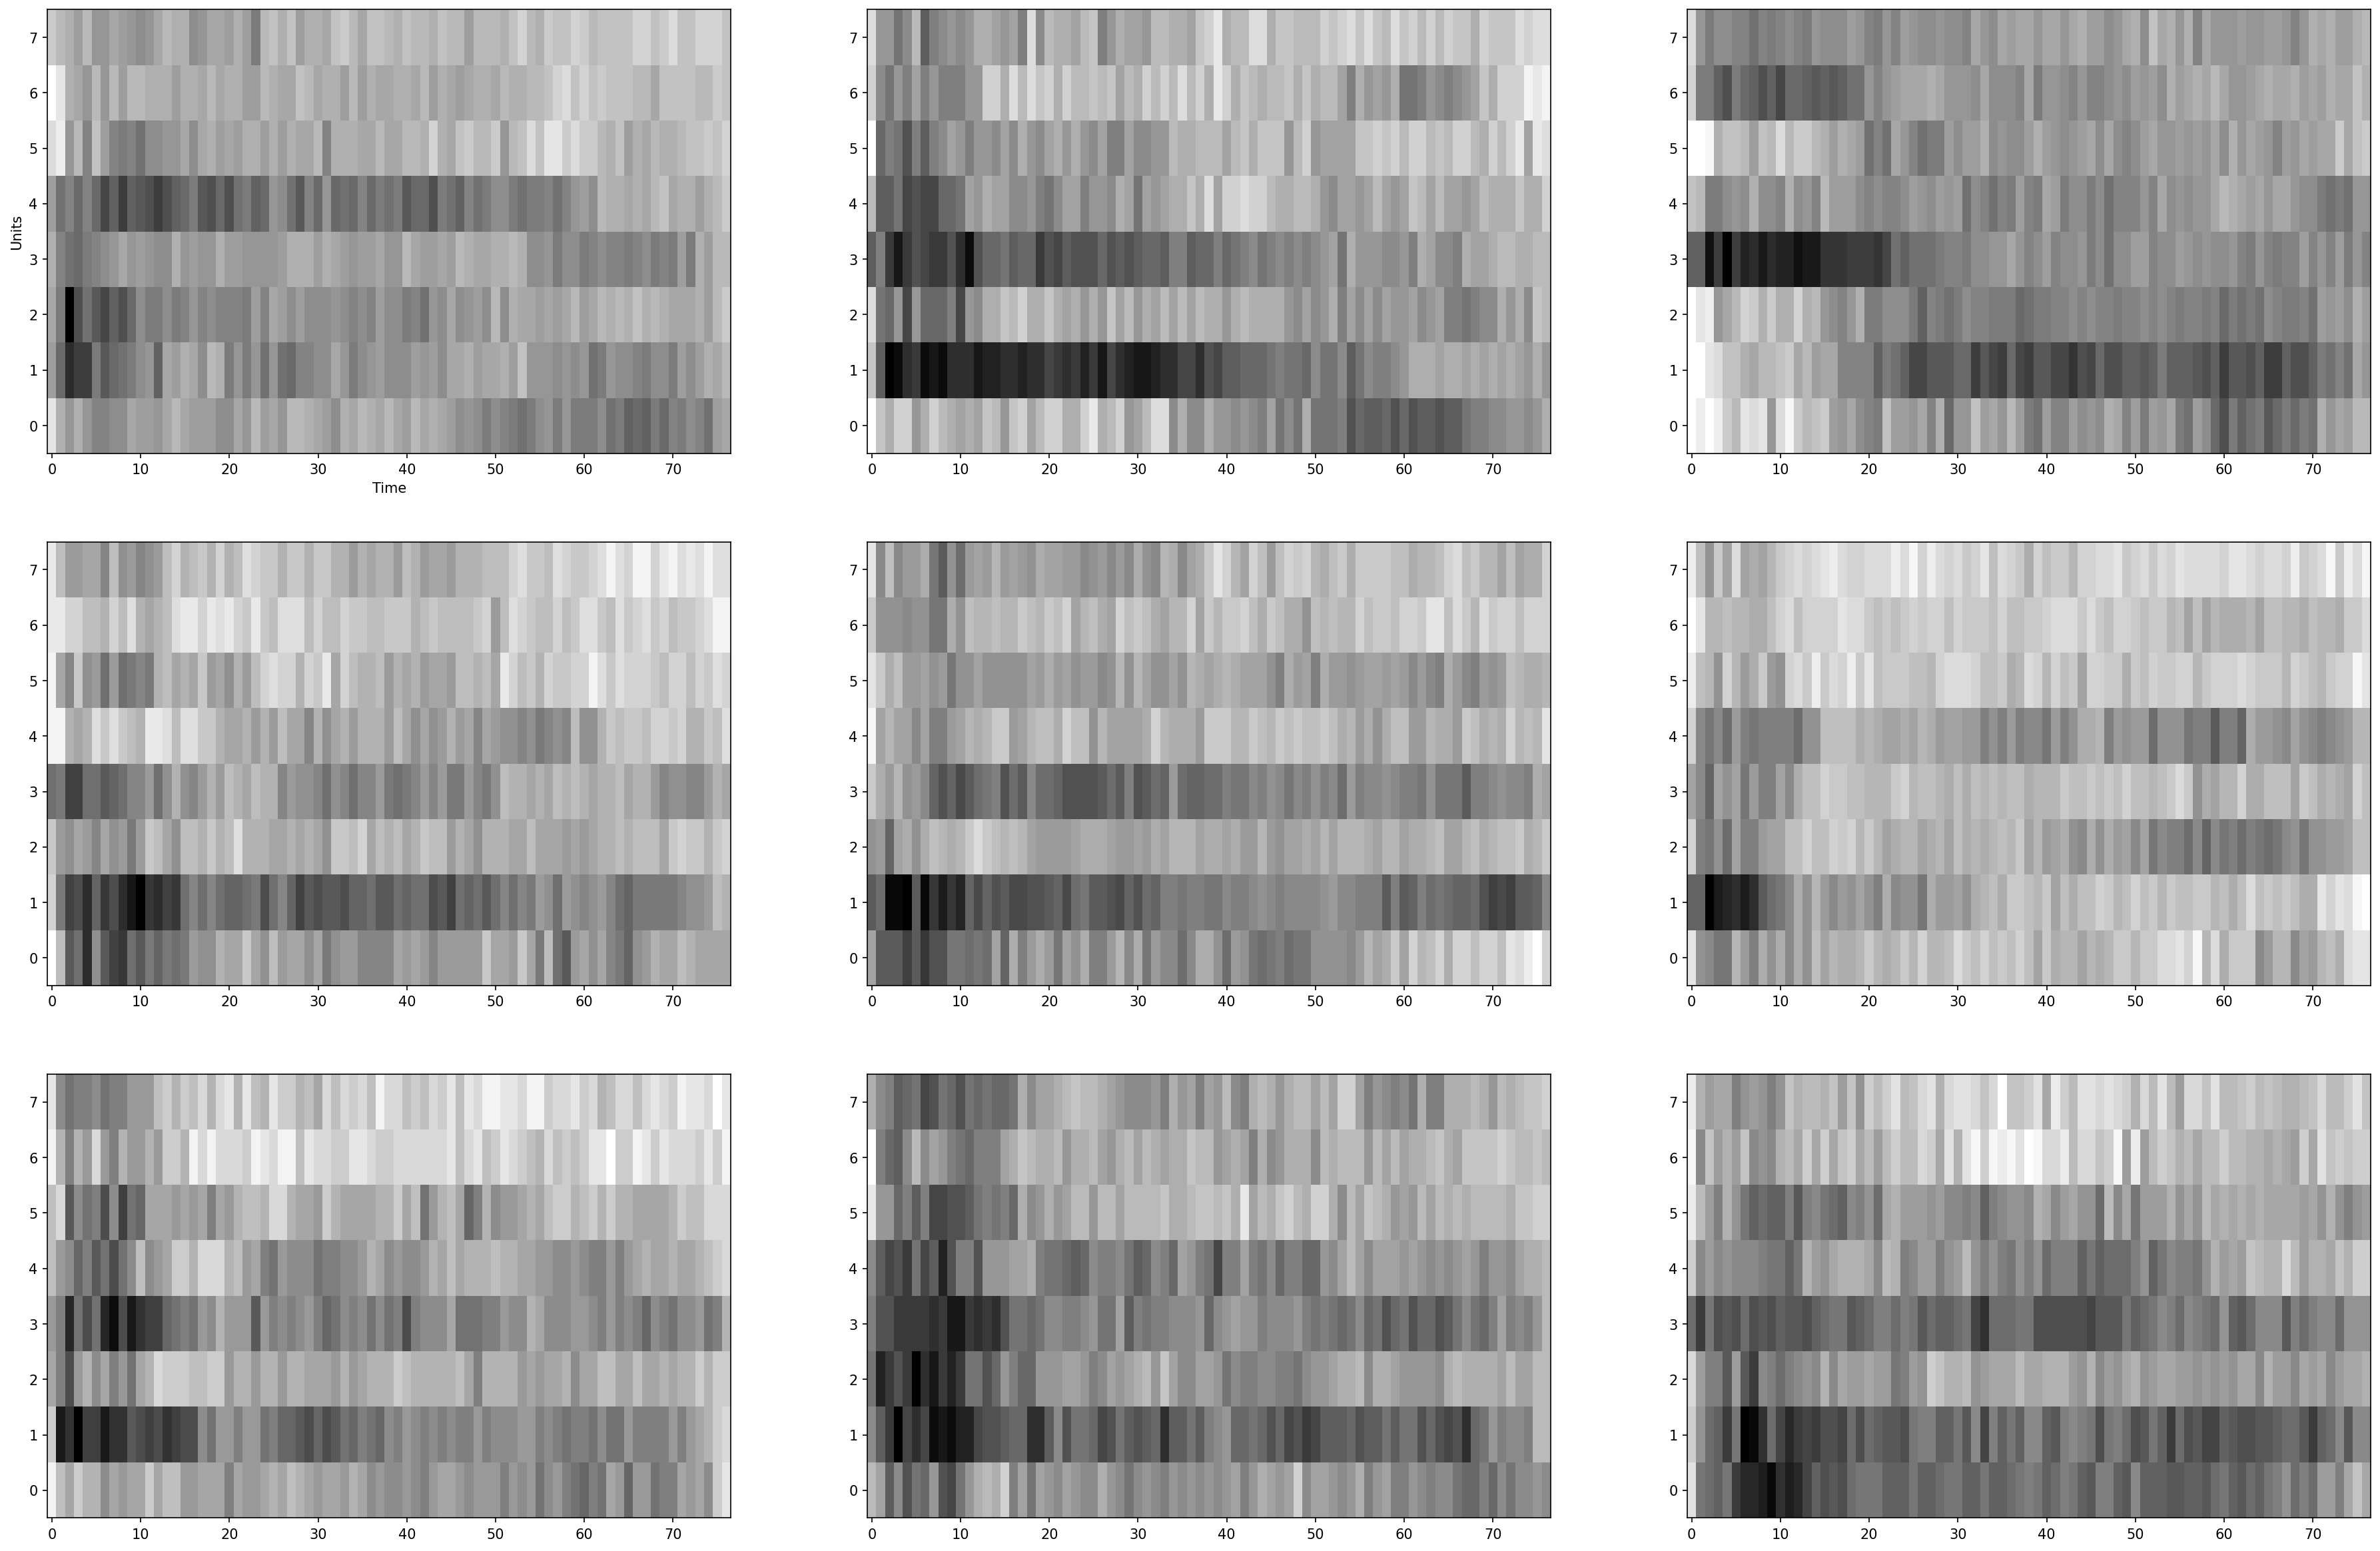

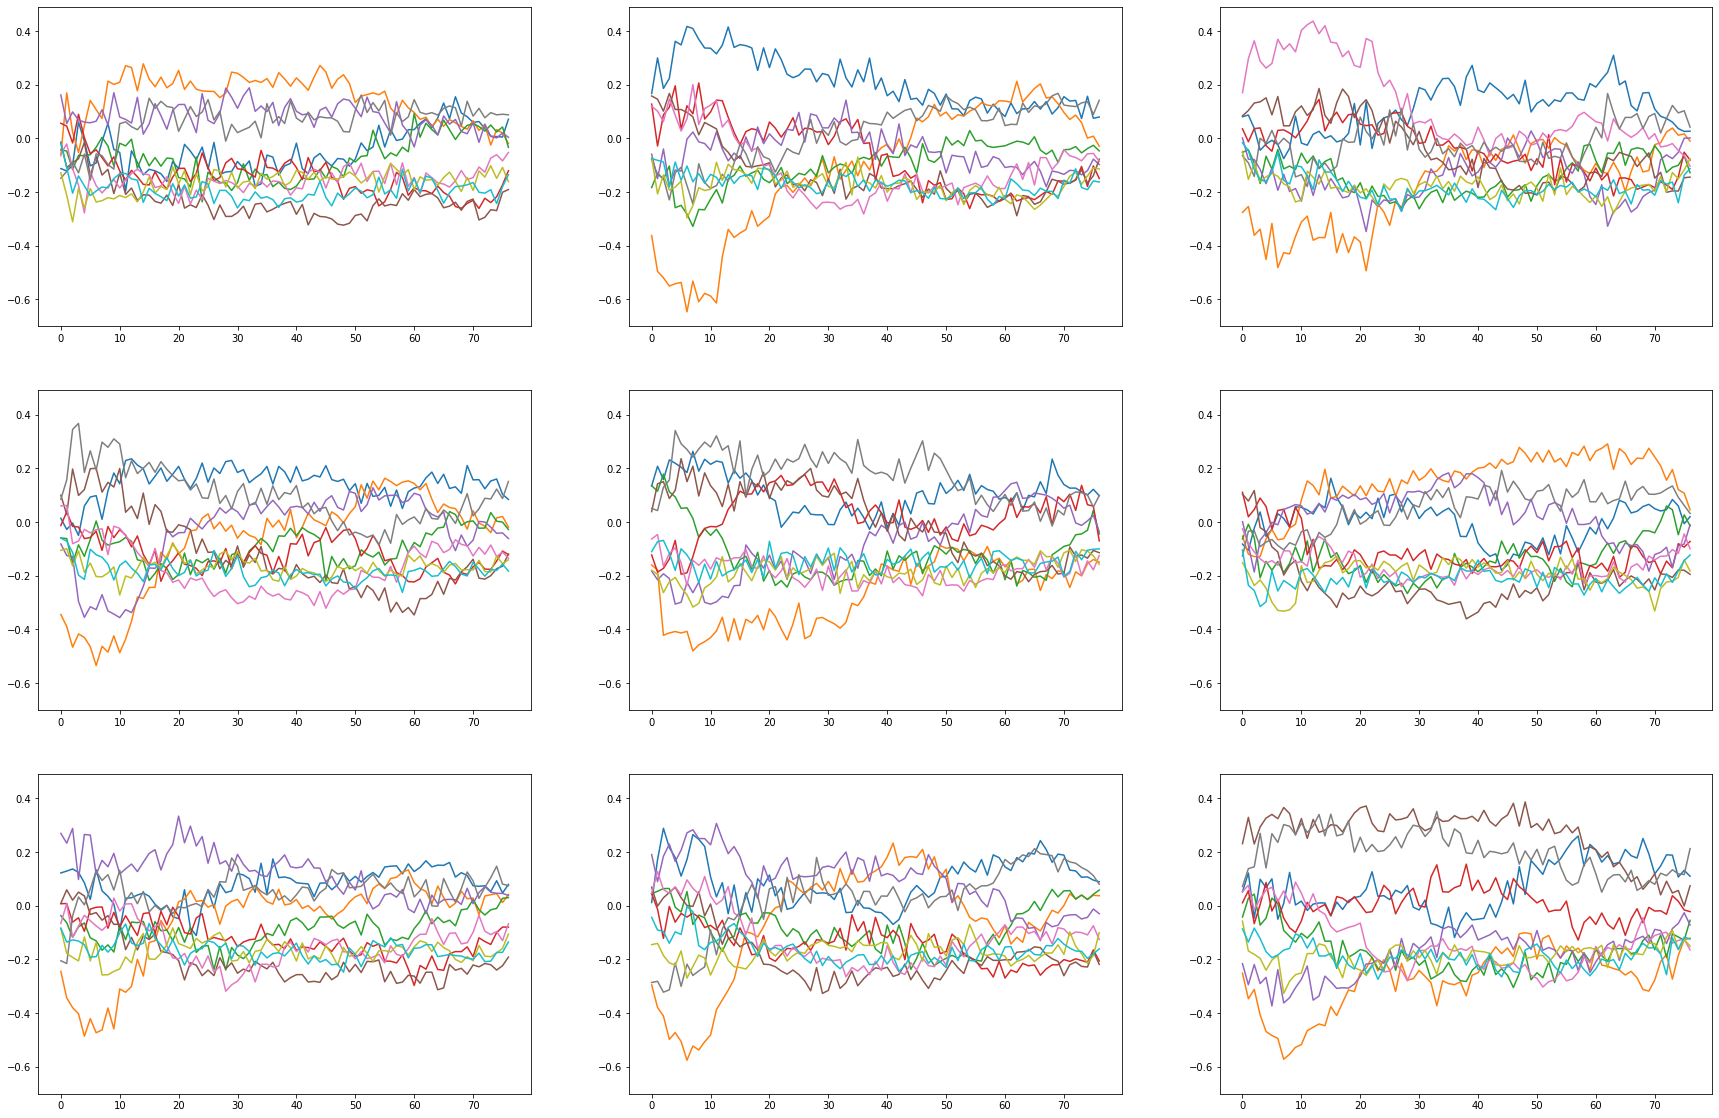

In [16]:
snn(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

# Streaming data test

In [17]:
from streamload import EMGStream, PSD, STFT, PSDNoDelta, NoFeatureExtraction, Rescale

def compute_classification_accuracy(model, dataloader):
    accs = []
    cnt = 0
    
    with torch.no_grad():
        for x_batch, y_batch in dataloader:

            x_batch = x_batch.to(device, dtype)
            y_batch = y_batch.to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)

            if cnt%15 == 0:
                print("Estimation: ", tmp, "SNN output: ", am.item(), "Label: ", y_batch.item())
                print("Batches estimated: ", cnt)
                print("Avg accuracy: %0.3f"%np.mean(accs))
            cnt+=1

    return np.mean(accs)

fn = "../raw/2_raw_data_1.txt"
bat_size = 15
buff_size = 150  # a multiple of bat_size

stft = STFT(n_fft, hop_length)
psd = PSD(sr, n_fft)
psdnodelta = PSDNoDelta(sr, n_fft)
nfe = NoFeatureExtraction()

rescale = Rescale()

if MODE == 0:
    transform = torchvision.transforms.Compose([nfe, rescale])
    in_chan = 1
    in_sh = 8
elif MODE == 1:
    transform = torchvision.transforms.Compose([psd, rescale])
    in_chan = 2
    in_sh = 8
elif MODE == 2:
    transform = torchvision.transforms.Compose([stft, rescale])
    in_chan = 8
    in_sh = 52
elif MODE == 3:
    transform = torchvision.transforms.Compose([psdnodelta, rescale])
    in_chan = 1
    in_sh = 8
else:
    print("Incorect mode, using no transform")
    transform = torchvision.transforms.Compose([nfs, rescale])
    in_chan = 1
    in_sh = 8



stream_loader = EMGStream(fn, bat_size, buff_size, transform=transform, shuffle=False)
test_accuracy = compute_classification_accuracy(snn, stream_loader)
print("Test accuracy=%.3f"%(test_accuracy))


Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  0
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  15
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  30
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  45
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  60
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  75
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  90
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  105
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  120
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  135
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  150
Avg accuracy: 0.000
Estimation:  0.0 SNN output:  5 Label:  6
Batches estimated:  

Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  1440
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  1
Batches estimated:  1455
Avg accuracy: 0.007
Estimation:  1.0 SNN output:  1 Label:  1
Batches estimated:  1470
Avg accuracy: 0.014
Estimation:  0.0 SNN output:  6 Label:  1
Batches estimated:  1485
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  1500
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  1515
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  1530
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  1545
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  1560
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  1575
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  1590
Avg accuracy: 0.013
Estimation:  0.0 SNN output:  6 Label:  7
B

Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2865
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2880
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2895
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2910
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2925
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2940
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2955
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2970
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  2985
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  3000
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
Batches estimated:  3015
Avg accuracy: 0.007
Estimation:  0.0 SNN output:  6 Label:  7
B

Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4290
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4305
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4320
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4335
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4350
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4365
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4380
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4395
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4410
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4425
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  4440
Avg accuracy: 0.005
Estimation:  0.0 SNN output:  3 Label:  4
B

Estimation:  0.0 SNN output:  7 Label:  1
Batches estimated:  5715
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  7 Label:  1
Batches estimated:  5730
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  5745
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  5760
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  5775
Avg accuracy: 0.012
Estimation:  1.0 SNN output:  1 Label:  1
Batches estimated:  5790
Avg accuracy: 0.014
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  5805
Avg accuracy: 0.014
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  5820
Avg accuracy: 0.014
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  5835
Avg accuracy: 0.014
Estimation:  0.0 SNN output:  1 Label:  2
Batches estimated:  5850
Avg accuracy: 0.014
Estimation:  0.0 SNN output:  1 Label:  2
Batches estimated:  5865
Avg accuracy: 0.014
Estimation:  0.0 SNN output:  1 Label:  2
B

Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  7140
Avg accuracy: 0.011
Estimation:  0.0 SNN output:  2 Label:  1
Batches estimated:  7155
Avg accuracy: 0.011
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  7170
Avg accuracy: 0.011
Estimation:  0.0 SNN output:  6 Label:  1
Batches estimated:  7185
Avg accuracy: 0.011
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  7200
Avg accuracy: 0.011
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  7215
Avg accuracy: 0.011
Estimation:  0.0 SNN output:  0 Label:  1
Batches estimated:  7230
Avg accuracy: 0.011
Estimation:  1.0 SNN output:  1 Label:  1
Batches estimated:  7245
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  6 Label:  1
Batches estimated:  7260
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  4 Label:  1
Batches estimated:  7275
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  2 Label:  1
Batches estimated:  7290
Avg accuracy: 0.012
Estimation:  0.0 SNN output:  6 Label:  7
B

Estimation:  0.0 SNN output:  4 Label:  5
Batches estimated:  8565
Avg accuracy: 0.011
Estimation:  0.0 SNN output:  6 Label:  5
Batches estimated:  8580
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  4 Label:  5
Batches estimated:  8595
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  4 Label:  5
Batches estimated:  8610
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  6 Label:  5
Batches estimated:  8625
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  8640
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  8655
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  8670
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  8685
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  8700
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  8715
Avg accuracy: 0.010
Estimation:  0.0 SNN output:  3 Label:  4
B

Estimation:  0.0 SNN output:  2 Label:  3
Batches estimated:  9990
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  2 Label:  3
Batches estimated:  10005
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  2 Label:  3
Batches estimated:  10020
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  2 Label:  3
Batches estimated:  10035
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  6 Label:  3
Batches estimated:  10050
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  6 Label:  3
Batches estimated:  10065
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  6 Label:  3
Batches estimated:  10080
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  6 Label:  3
Batches estimated:  10095
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  2 Label:  3
Batches estimated:  10110
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  6 Label:  3
Batches estimated:  10125
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  6 Label:  3
Batches estimated:  10140
Avg accuracy: 0.009
Estimation:  0.0 SNN output:  2 L

Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11400
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11415
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11430
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11445
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11460
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11475
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11490
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11505
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11520
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11535
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 Label:  4
Batches estimated:  11550
Avg accuracy: 0.008
Estimation:  0.0 SNN output:  3 